In [1]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
import tensorflow as tf
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras import backend as K
import os
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Input, concatenate, AveragePooling2D, Dropout,Attention,Multiply,BatchNormalization,Dropout
import time

# Setting Databases Path

In [2]:
train_dir = r'D:\archive\fruits-360-original-size\fruits-360-original-size\Training1'
test_dir = r'D:\archive\fruits-360-original-size\fruits-360-original-size\Test'

In [3]:
input_shape=(128, 128, 3)
batch_size=16
num_classes=24

# Data Preprocessing

In [4]:
train_datagen=ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2,
    # test_split=0.2,
)

validation_datagen=ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=False
)

test_datagen=ImageDataGenerator(
    rescale=1./255)

train_generator=train_datagen.flow_from_directory(
    train_dir,
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='rgb',
    subset='training'
)

validation_generator=train_datagen.flow_from_directory(
    train_dir,
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='rgb',
    subset='validation'
)

test_generator=test_datagen.flow_from_directory(
    test_dir,
    shuffle=False,
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='rgb'
)

Found 7485 images belonging to 24 classes.
Found 1860 images belonging to 24 classes.
Found 3110 images belonging to 24 classes.


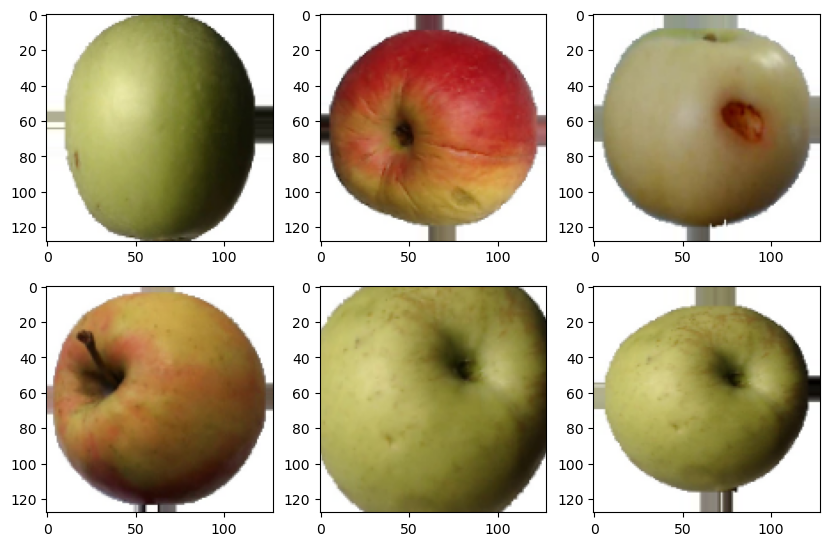

In [76]:
plt.figure(figsize=(10,10))
for i in range(6):
    #gera subfigures
    plt.subplot(330 + 1 + i)
    batch = train_generator.next()[0]*255
    image = batch[0].astype('uint8')
    plt.imshow(image)
plt.show()

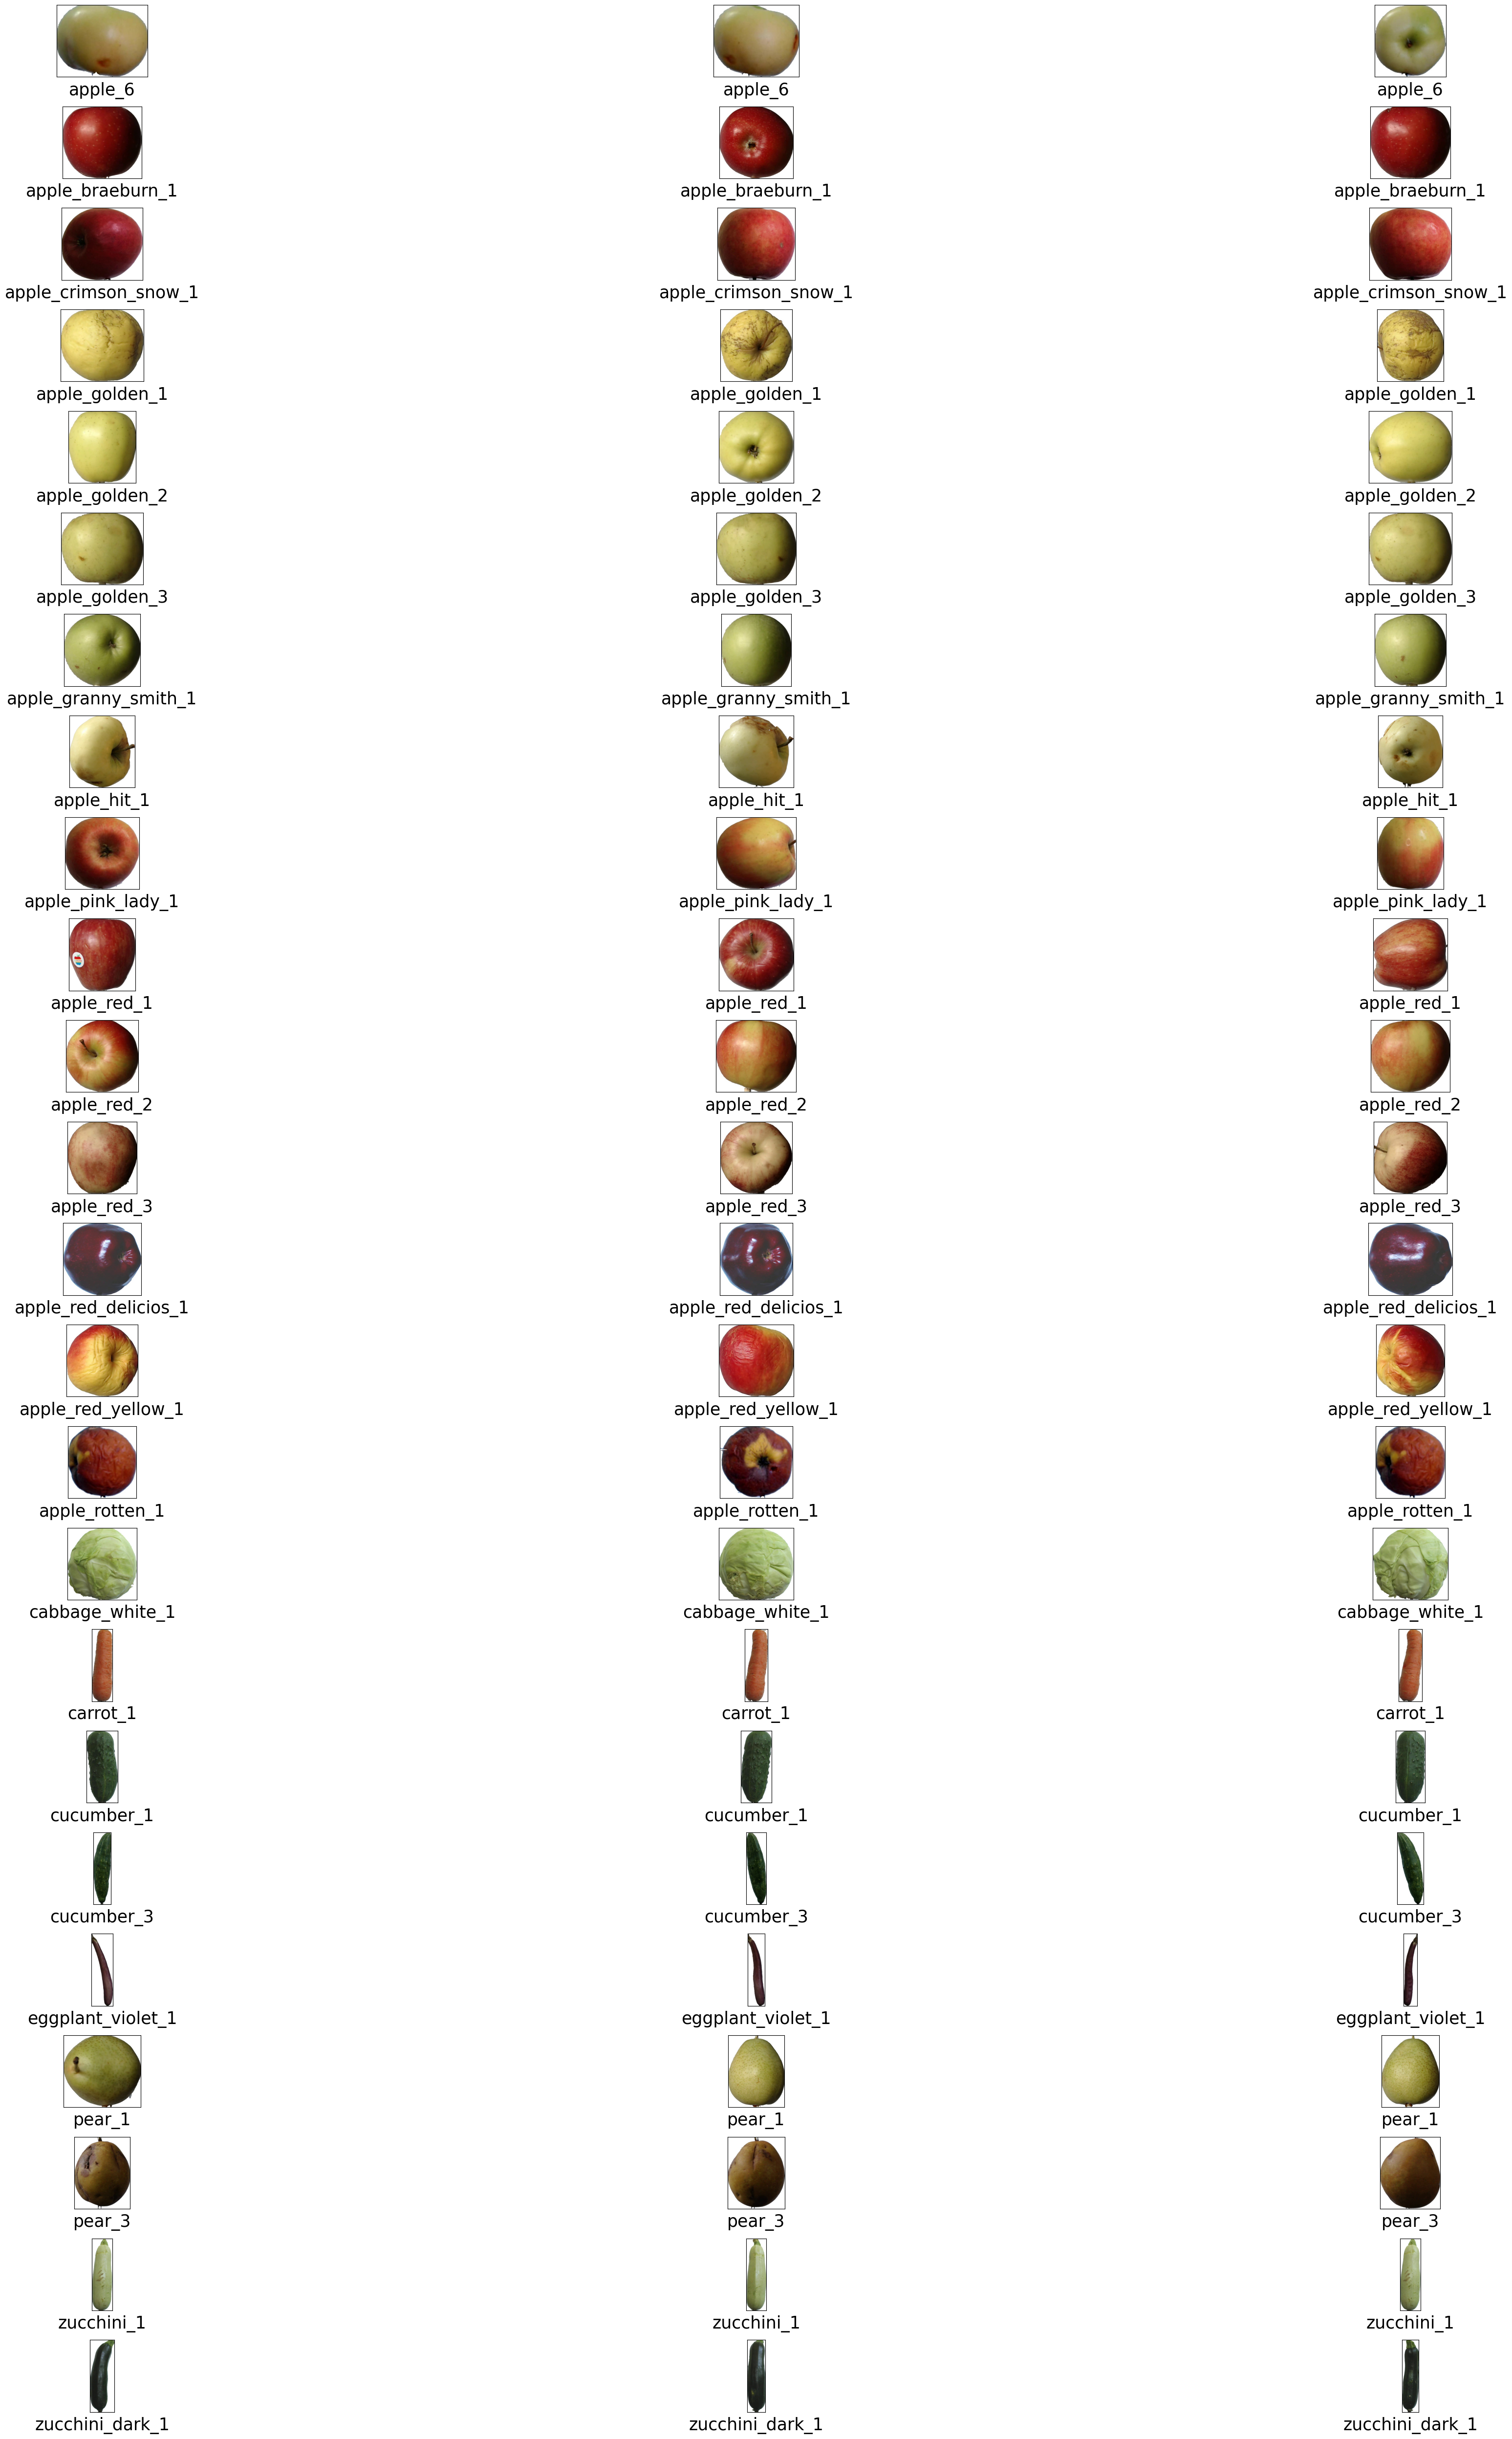

In [77]:
from random import sample
import os
from PIL import Image
import matplotlib.pyplot as plt

fig, axs = plt.subplots(num_classes, 3, figsize=(50, 50))
# 假设train_dir是包含每个类别子目录的目录
class_names = os.listdir(train_dir)

for i, item in enumerate(class_names):
    images = sample(os.listdir(os.path.join(train_dir, item)), 3)

    for j, image in enumerate(images):
        img_path = os.path.join(train_dir, item, image)
        img = Image.open(img_path)
        axs[i, j].set_xlabel(item, fontsize=25)
        axs[i, j].imshow(img)
        axs[i, j].set(xlabel=item, xticks=[], yticks=[])

fig.tight_layout()
plt.show()

# construct the models

In [6]:
def model1(input_shape=input_shape, num_classes=num_classes):
    model = Sequential()

    model.add(Conv2D(16, kernel_size=(3, 3), activation='relu', input_shape=input_shape, padding="same"))
    model.add(BatchNormalization())
    model.add(AveragePooling2D(pool_size=(2, 2), padding='same'))
    model.add(Dropout(0.3))

    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(AveragePooling2D(pool_size=(2, 2), padding='same'))

    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(AveragePooling2D(pool_size=(2, 2), padding='same'))
    model.add(Dropout(0.3))

    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))

    model.add(Dense(num_classes, activation='softmax'))

    return model


def model2(input_shape=input_shape, num_classes=num_classes):
    model = Sequential()

    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape, padding="same"))
    model.add(BatchNormalization())
    model.add(AveragePooling2D((2, 2), padding='same'))
    model.add(Dropout(0.3))

    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(AveragePooling2D((2, 2), strides=(2, 2)))

    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(AveragePooling2D((2, 2), strides=(2, 2)))
    model.add(Dropout(0.3))

    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.3))

    model.add(Dense(num_classes, activation='softmax'))

    return model

# Combine the two models into an ensemble model
def create_ensemble_model_with_attention(input_shape, num_classes):
    input_layer = Input(shape=input_shape)

    modelA = model1(input_shape, num_classes)(input_layer)
    modelB = model2(input_shape, num_classes)(input_layer)
    attention = Attention()([modelA, modelB])
    attended_model2 = Multiply()([modelB, attention])
    merged = concatenate([modelA, attended_model2])
    dense = Dense(128, activation='relu')(merged)
    Dropout(0.3)(dense)
    output_layer = Dense(num_classes, activation='softmax')(dense)

    model = Model(inputs=input_layer, outputs=output_layer)

    return model


In [7]:
def custom_loss(y_true, y_pred):
    mse = MeanSquaredError()(y_true, y_pred)
    regularization = K.sum(K.square(y_pred - y_true), axis=-1)

    loss = mse + 0.005 * regularization
    return loss

def custom_accuracy(y_true, y_pred):
    y_true_labels = tf.argmax(y_true, axis=-1)
    y_pred_labels = tf.argmax(y_pred, axis=-1)
    accuracy = tf.reduce_mean(tf.cast(tf.equal(y_true_labels, y_pred_labels), tf.float32))
    return accuracy

In [8]:
input_shape = (128, 128, 3)
num_classes = 24 #benign and malignant

# Train the model1

In [ ]:
model1=model1(input_shape, num_classes)
model1.summary()

optimizer = Adam(learning_rate=0.001)
# reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.0001)

start_time = time.time()
model1.compile(loss=custom_loss, optimizer=optimizer, metrics=[custom_accuracy])
history=model1.fit(train_generator, epochs=10, validation_data=(validation_generator), verbose=1)

end_time = time.time()
training_time = end_time - start_time
print(f"Training time: {training_time} seconds")


In [ ]:
test_loss, test_acc = model1.evaluate(test_generator)
print('Test loss:', test_loss)
print('Test accuracy:', test_acc)

# Train the model2

In [ ]:
model2=model2(input_shape, num_classes)
model2.summary()

optimizer = Adam(learning_rate=0.001)
# reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.0001)

start_time = time.time()
model2.compile(loss=custom_loss, optimizer=optimizer, metrics=[custom_accuracy])
history=model2.fit(train_generator, epochs=10, validation_data=(validation_generator), verbose=1)

end_time = time.time()
training_time = end_time - start_time
print(f"Training time: {training_time} seconds")

In [ ]:
test_loss, test_acc = model2.evaluate(test_generator)
print('Test loss:', test_loss)
print('Test accuracy:', test_acc)

# Train the ensemble model

In [9]:
ensemble_model = create_ensemble_model_with_attention(input_shape,num_classes)
ensemble_model.summary()

optimizer = Adam(learning_rate=0.001)
ensemble_model.compile(loss=custom_loss, optimizer=optimizer, metrics=[custom_accuracy])

start_time = time.time()
history=ensemble_model.fit(train_generator, epochs=10, validation_data=(validation_generator), verbose=1)
end_time = time.time()

training_time = end_time - start_time
print(f"Training time: {training_time} seconds")


Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 24)           2124920     input_1[0][0]                    
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 24)           4291672     input_1[0][0]                    
__________________________________________________________________________________________________
attention (Attention)           (None, 24)           0           sequential[0][0]                 
                                                                 sequential_1[0][0]    

In [76]:
test_loss, test_acc = ensemble_model.evaluate(test_generator)
print('Test loss:', test_loss)
print('Test accuracy:', test_acc)

195/195 [==============================] - 13s 69ms/step - loss: 9.8026e-04 - custom_accuracy: 0.9891
Test loss: 0.0009802633430808783
Test accuracy: 0.9891025424003601


# Get the performance of each moodel

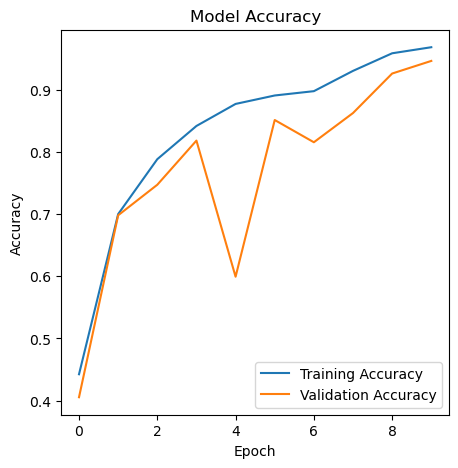

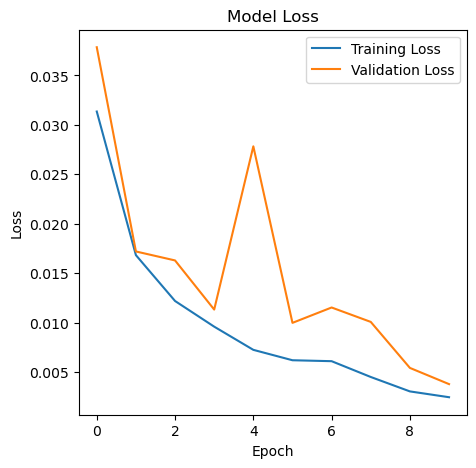

In [62]:
plt.figure(figsize=(5,5))
plt.plot(history.history['custom_accuracy'])
plt.plot(history.history['val_custom_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Training Accuracy', 'Validation Accuracy'], loc ='lower right')
plt.show()

plt.figure(figsize=(5,5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Training Loss', 'Validation Loss'], loc ='upper right')
plt.show()

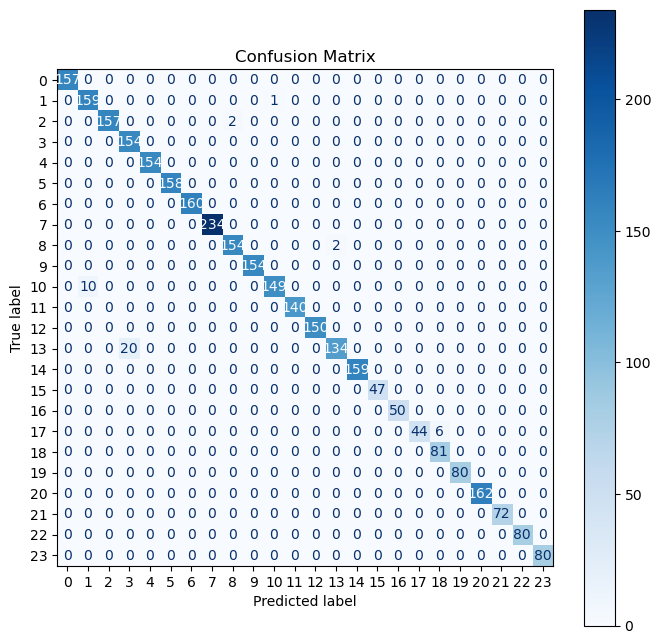


Classification Report:
                      precision    recall  f1-score   support

             apple_6       1.00      1.00      1.00       157
    apple_braeburn_1       0.94      0.99      0.97       160
apple_crimson_snow_1       1.00      0.99      0.99       159
      apple_golden_1       0.89      1.00      0.94       154
      apple_golden_2       1.00      1.00      1.00       154
      apple_golden_3       1.00      1.00      1.00       158
apple_granny_smith_1       1.00      1.00      1.00       160
         apple_hit_1       1.00      1.00      1.00       234
   apple_pink_lady_1       0.99      0.99      0.99       156
         apple_red_1       1.00      1.00      1.00       154
         apple_red_2       0.99      0.94      0.96       159
         apple_red_3       1.00      1.00      1.00       140
apple_red_delicios_1       1.00      1.00      1.00       150
  apple_red_yellow_1       0.99      0.87      0.92       154
      apple_rotten_1       1.00      1.00    

In [11]:
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt

y_pred = ensemble_model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_generator.classes

conf_matrix = confusion_matrix(y_true, y_pred_classes)

# 调整图形尺寸
fig, ax = plt.subplots(figsize=(8, 8))

# 生成混淆矩阵图
disp = ConfusionMatrixDisplay(conf_matrix, display_labels=np.unique(y_true))
disp.plot(cmap=plt.cm.Blues, values_format='d', ax=ax)
plt.title('Confusion Matrix')
plt.show()

class_names = list(test_generator.class_indices.keys())
print("\nClassification Report:")
print(classification_report(y_true, y_pred_classes, target_names=class_names))

In [78]:
from sklearn.metrics import f1_score

f1=f1_score(y_true,y_pred_classes,average='weighted')
print('F1-score:', f1)

F1-score: 0.9890284966741018


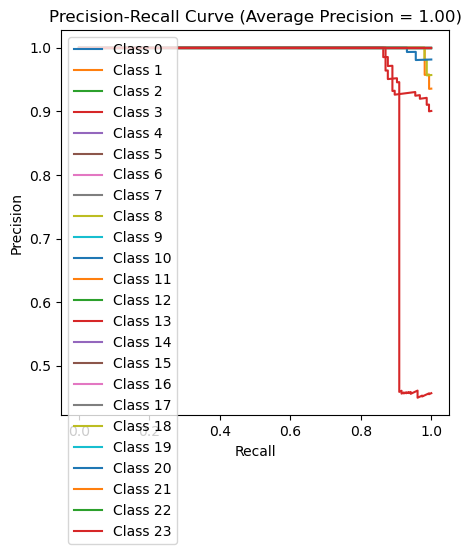

In [12]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
from sklearn.metrics import average_precision_score

# 获取类别数量
n_classes = num_classes

# 将真实标签进行二进制编码
y_true_bin = label_binarize(y_true, classes=range(n_classes))

# 计算每个类别的精确度、召回率和阈值
precision = dict()
recall = dict()
thresholds = dict()

for i in range(n_classes):
    precision[i], recall[i], thresholds[i] = precision_recall_curve(y_true_bin[:, i], y_pred[:, i])

# 计算平均精确度
average_precision = average_precision_score(y_true_bin, y_pred, average='weighted')

# 绘制每个类别的精确度-召回率曲线
plt.figure(figsize=(5, 5))
for i in range(n_classes):
    plt.plot(recall[i], precision[i], label=f'Class {i}')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title(f'Precision-Recall Curve (Average Precision = {average_precision:.2f})')
plt.legend()
plt.show()


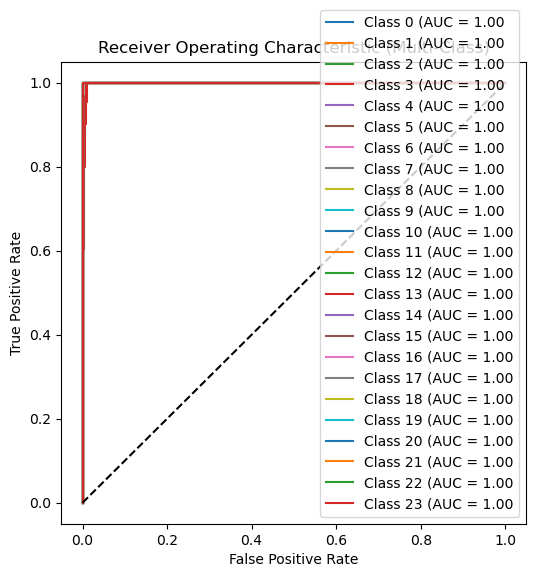

In [86]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# 计算每个类别的 ROC 曲线和 AUC
fpr = dict()
tpr = dict()
roc_auc = dict()

for class_label in range(num_classes):
    fpr[class_label], tpr[class_label], _ = roc_curve(
        (y_true == class_label).astype(int),  # 二进制标签，表示当前类别为正类
        y_pred[:, class_label]  # 模型的预测概率值
    )

    roc_auc[class_label] = auc(fpr[class_label], tpr[class_label])

# 绘制多分类问题的 ROC 曲线
plt.figure(figsize=(6, 6))

for class_label in range(num_classes):
    plt.plot(fpr[class_label], tpr[class_label], label=f'Class {class_label} (AUC = {roc_auc[class_label]:.2f}')

plt.plot([0, 1], [0, 1], 'k--')
plt.title('Receiver Operating Characteristic (Multi-Class)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

In [82]:
from sklearn.metrics import confusion_matrix

# 计算混淆矩阵
conf_matrix = confusion_matrix(y_true, y_pred_classes)

# 计算每个类别的敏感性和特异性
num_classes = len(class_names)
sensitivity = []
specificity = []

for i in range(num_classes):
    # True positive
    tp = conf_matrix[i, i]

    # False negative
    fn = np.sum(conf_matrix[i, :]) - tp

    # False positive
    fp = np.sum(conf_matrix[:, i]) - tp

    # True negative
    tn = np.sum(conf_matrix) - tp - fn - fp

    # 计算敏感性和特异性
    sensitivity.append(tp / (tp + fn))
    specificity.append(tn / (tn + fp))

# 输出结果
for i in range(num_classes):
    print(f"Class {class_names[i]} - Sensitivity: {sensitivity[i]:.4f}, Specificity: {specificity[i]:.4f}")

# 计算平均敏感性和特异性
average_sensitivity = np.mean(sensitivity)
average_specificity = np.mean(specificity)

print(f"\nAverage Sensitivity: {average_sensitivity:.4f}")
print(f"Average Specificity: {average_specificity:.4f}")


Class apple_6 - Sensitivity: 1.0000, Specificity: 1.0000
Class apple_braeburn_1 - Sensitivity: 1.0000, Specificity: 0.9956
Class apple_crimson_snow_1 - Sensitivity: 1.0000, Specificity: 1.0000
Class apple_golden_1 - Sensitivity: 1.0000, Specificity: 0.9929
Class apple_golden_2 - Sensitivity: 1.0000, Specificity: 1.0000
Class apple_golden_3 - Sensitivity: 1.0000, Specificity: 1.0000
Class apple_granny_smith_1 - Sensitivity: 1.0000, Specificity: 1.0000
Class apple_hit_1 - Sensitivity: 1.0000, Specificity: 1.0000
Class apple_pink_lady_1 - Sensitivity: 1.0000, Specificity: 1.0000
Class apple_red_1 - Sensitivity: 1.0000, Specificity: 1.0000
Class apple_red_2 - Sensitivity: 0.9182, Specificity: 1.0000
Class apple_red_3 - Sensitivity: 1.0000, Specificity: 1.0000
Class apple_red_delicios_1 - Sensitivity: 1.0000, Specificity: 1.0000
Class apple_red_yellow_1 - Sensitivity: 0.8636, Specificity: 1.0000
Class apple_rotten_1 - Sensitivity: 1.0000, Specificity: 1.0000
Class cabbage_white_1 - Sensitiv